In [1]:
# Simple implementation of a custom layer
import tensorflow as tf
import numpy as np
from keras import Model, layers, Input
from keras.optimizers import Adam

In [2]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences


# load the IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# pad the sequences to the same length
x_train = pad_sequences(x_train, maxlen=200)
x_test = pad_sequences(x_test, maxlen=200)


In [3]:
layers = tf.keras.layers
class MultiHeadSelfAttentionNoScaling(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttentionNoScaling, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0  # check if embed_dim is divisible by num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True) # (batch_size, seq_len, seq_len)
        #dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # scalar value of the last dimension of key
        # no scale, Do we say exploding gradient problems?
        #scaled_score = score / tf.math.sqrt(dim_key) # (batch_size, seq_len, seq_len) / scalar
        weights = tf.nn.softmax(score, axis=-1) # (batch_size, seq_len, seq_len)

        output = tf.matmul(weights, value)
        # (batch_size, seq_len, seq_len) * (batch_size, num_heads, seq_len, embed_dim/num_heads) = (batch_size, num_heads, seq_len, embed_dim/num_heads)

        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.embed_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, embed_dim/num_heads)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        return output




In [27]:
# with scaling
layers = tf.keras.layers
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0  # check if embed_dim is divisible by num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True) # (batch_size, seq_len, seq_len)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # scalar value of the last dimension of key
        #scale the score to avoid the gradient vanishing problem
        scaled_score = score / tf.math.sqrt(dim_key) # (batch_size, seq_len, seq_len) / scalar
        weights = tf.nn.softmax(scaled_score, axis=-1) # (batch_size, seq_len, seq_len)

        output = tf.matmul(weights, value)
        # (batch_size, seq_len, seq_len) * (batch_size, num_heads, seq_len, embed_dim/num_heads) = (batch_size, num_heads, seq_len, embed_dim/num_heads)

        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.embed_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, embed_dim/num_heads)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        return output


In [35]:

# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
# Find the maximum word index in x_train and x_test
max_word_index = max(np.max(x_train), np.max(x_test))
# Set vocab_size to be at least as large as max_word_index + 1
vocab_size = max_word_index + 1  # Add 1 because word indices start from 1
max_sequence_length = x_train.shape[1]  # The length of each sequence

# Define the model
inputs = Input(shape=(max_sequence_length,))
embedding_layer = layers.Embedding(vocab_size, embed_dim)(inputs)
attention_layer = MultiHeadSelfAttentionNoScaling(embed_dim, num_heads)(embedding_layer)
pooling_layer = layers.GlobalAveragePooling1D()(attention_layer)
outputs = layers.Dense(1, activation='sigmoid')(pooling_layer)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9),
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
782/782 [==============================] - 23s 29ms/step - loss: 0.6954 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
782/782 [==============================] - 23s 29ms/step - loss: 0.6934 - accuracy: 0.5176 - val_loss: 0.6800 - val_accuracy: 0.5504
Epoch 3/5
782/782 [==============================] - 23s 30ms/step - loss: 0.5324 - accuracy: 0.7188 - val_loss: 0.3416 - val_accuracy: 0.8512
Epoch 4/5
782/782 [==============================] - 23s 29ms/step - loss: 0.3455 - accuracy: 0.8512 - val_loss: 0.3030 - val_accuracy: 0.8700
Epoch 5/5
782/782 [==============================] - 23s 30ms/step - loss: 0.2801 - accuracy: 0.8836 - val_loss: 0.3120 - val_accuracy: 0.8713


In [36]:
# loss of 0.0788
# Evaluating the model
model.evaluate(x_test, y_test)

# with scaling:
# 782/782 [==============================] - 6s 7ms/step - loss: 0.3520 - accuracy: 0.8654


# without scaling 2 epochs:
# 782/782 [==============================] - 6s 7ms/step - loss: 0.3401 - accuracy: 0.8675

# without scaling 10 epochs:
# 782/782 [==============================] - 6s 8ms/step - loss: 1.3061 - accuracy: 0.8311
# it overfits

# without scaling 2 epochs SGD 0.1 momentum 0:
# 782/782 [==============================] - 7s 9ms/step - loss: 0.6932 - accuracy: 0.5000

# without scaling 2 epochs SGD 0.1 momentum 0.9:
# 782/782 [==============================] - 22s 28ms/step - loss: 0.6946 - accuracy: 0.5096 - val_loss: 0.6902 - val_accuracy: 0.5024
# it does not learn
# this can be contrasted with the scaling version that learns

# without scaling 5 epochs SGD 0.1 momentum 0.9:
# 782/782 [==============================] - 8s 11ms/step - loss: 0.3120 - accuracy: 0.8713
# it learns

782/782 [==============================] - 8s 11ms/step - loss: 0.3120 - accuracy: 0.8713


[0.3119722902774811, 0.8712800145149231]

In [49]:
# Second model with more layers to provoque exploding gradient
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
# Find the maximum word index in x_train and x_test
max_word_index = max(np.max(x_train), np.max(x_test))
# Set vocab_size to be at least as large as max_word_index + 1
vocab_size = max_word_index + 1  # Add 1 because word indices start from 1
max_sequence_length = x_train.shape[1]  # The length of each sequence

# Define the model
inputs = Input(shape=(max_sequence_length,))
embedding_layer = layers.Embedding(vocab_size, embed_dim)(inputs)
attention_layer = MultiHeadSelfAttentionNoScaling(embed_dim, num_heads)(embedding_layer)
pooling_layer = layers.GlobalAveragePooling1D()(attention_layer)
attention_layer2 = MultiHeadSelfAttentionNoScaling(embed_dim, num_heads)(pooling_layer)
pooling_layer2 = layers.GlobalAveragePooling1D()(attention_layer2)
attention_layer3 = MultiHeadSelfAttentionNoScaling(embed_dim, num_heads)(pooling_layer2)
pooling_layer3 = layers.GlobalAveragePooling1D()(attention_layer3)
outputs = layers.Dense(1, activation='sigmoid')(pooling_layer3)

model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model2.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=0.5, momentum=0.9),
              metrics=['accuracy'])

# Train the model
model2.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))


Epoch 1/2
781/782 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.5020

KeyboardInterrupt: 

In [39]:
# model 2 evaluation

model2.evaluate(x_test, y_test)

# without scaling 2 epochs:
# 782/782 [==============================] - 6s 8ms/step - loss: 0.3633 - accuracy: 0.8618

# without scaling 4 epochs(overfitting):
# 782/782 [==============================] - 6s 8ms/step - loss: 0.7406 - accuracy: 0.8426

# without scaling 2 epochs SGD 0.01 momentum 0:
# 782/782 [==============================] - 7s 8ms/step - loss: 0.6933 - accuracy: 0.5000
# it doesn't learn

# without scaling 2 epochs SGD 0.03 momentum 0:
# 782/782 [==============================] - 7s 9ms/step - loss: 0.6928 - accuracy: 0.5163
# it doesn't learn

# without scaling 2 epochs SGD 0.1 momentum 0:
# 782/782 [==============================] - 7s 9ms/step - loss: 0.6955 - accuracy: 0.5000
# it doesn't learn

# without scaling 2 epochs SGD 0.1 momentum 1:
# 782/782 [==============================] - 8s 10ms/step - loss: 0.6989 - accuracy: 0.5000

# without scaling 5 epochs SGD 1, momentum 0.9:
# exploding gradient in first epoch, loss is NaN

# without scaling 5 epochs SGD 0.1, momentum 0.9:
# 782/782 [==============================] - 8s 11ms/step - loss: 0.3999 - accuracy: 0.8118


782/782 [==============================] - 8s 11ms/step - loss: 0.3999 - accuracy: 0.8118


[0.3999256491661072, 0.8118000030517578]

In [33]:
# model 1 but with scaling
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
# Find the maximum word index in x_train and x_test
max_word_index = max(np.max(x_train), np.max(x_test))
# Set vocab_size to be at least as large as max_word_index + 1
vocab_size = max_word_index + 1  # Add 1 because word indices start from 1
max_sequence_length = x_train.shape[1]  # The length of each sequence

# Define the model
inputs = Input(shape=(max_sequence_length,))
embedding_layer = layers.Embedding(vocab_size, embed_dim)(inputs)
attention_layer = MultiHeadSelfAttention(embed_dim, num_heads)(embedding_layer)
pooling_layer = layers.GlobalAveragePooling1D()(attention_layer)
outputs = layers.Dense(1, activation='sigmoid')(pooling_layer)

model3 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model3.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9),
              metrics=['accuracy'])

# Train the model
model3.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 23s 29ms/step - loss: 0.6954 - accuracy: 0.5086 - val_loss: 0.6917 - val_accuracy: 0.5004
Epoch 2/5
782/782 [==============================] - 23s 29ms/step - loss: 0.6791 - accuracy: 0.5566 - val_loss: 0.6644 - val_accuracy: 0.5701
Epoch 3/5
782/782 [==============================] - 23s 30ms/step - loss: 0.5091 - accuracy: 0.7441 - val_loss: 0.7652 - val_accuracy: 0.6556
Epoch 4/5
782/782 [==============================] - 23s 30ms/step - loss: 0.3345 - accuracy: 0.8566 - val_loss: 0.3491 - val_accuracy: 0.8446
Epoch 5/5
782/782 [==============================] - 23s 29ms/step - loss: 0.2726 - accuracy: 0.8892 - val_loss: 0.3025 - val_accuracy: 0.8751


In [34]:
# model 3 evaluation
model3.evaluate(x_test, y_test)

# with scaling 2 epochs SGD 0.1 momentum 0:
# 782/782 [==============================] - 7s 9ms/step - loss: 0.7029 - accuracy: 0.5000
# it doesn't learn

# with scaling 2 epochs SGD 0.1 momentum 0.9:
# 782/782 [==============================] - 7s 9ms/step - loss: 0.6292 - accuracy: 0.6448
# it learns, this can be contrasted with the non scaling version that doesn't learn

# with scaling 5 epochs SGD 0.1 momentum 0.9:
# 782/782 [==============================] - 7s 10ms/step - loss: 0.3025 - accuracy: 0.8751
# without scaling 5 epochs SGD 0.1 momentum 0.9:
# 782/782 [==============================] - 8s 11ms/step - loss: 0.3120 - accuracy: 0.8713
# so scaling is not necessary but it helps in this case



782/782 [==============================] - 7s 10ms/step - loss: 0.3025 - accuracy: 0.8751


[0.3025466501712799, 0.8751199841499329]

In [50]:
# model 4
# like model 2 but with scaling
# Second model with more layers to provoque exploding gradient
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
# Find the maximum word index in x_train and x_test
max_word_index = max(np.max(x_train), np.max(x_test))
# Set vocab_size to be at least as large as max_word_index + 1
vocab_size = max_word_index + 1  # Add 1 because word indices start from 1
max_sequence_length = x_train.shape[1]  # The length of each sequence

# Define the model
inputs = Input(shape=(max_sequence_length,))
embedding_layer = layers.Embedding(vocab_size, embed_dim)(inputs)
attention_layer = MultiHeadSelfAttention(embed_dim, num_heads)(embedding_layer)
pooling_layer = layers.GlobalAveragePooling1D()(attention_layer)
attention_layer2 = MultiHeadSelfAttention(embed_dim, num_heads)(pooling_layer)
pooling_layer2 = layers.GlobalAveragePooling1D()(attention_layer2)
attention_layer3 = MultiHeadSelfAttention(embed_dim, num_heads)(pooling_layer2)
pooling_layer3 = layers.GlobalAveragePooling1D()(attention_layer3)
outputs = layers.Dense(1, activation='sigmoid')(pooling_layer3)

model4 = Model(inputs=inputs, outputs=outputs)

# Compile the model
model4.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=0.5, momentum=0.9),
              metrics=['accuracy'])

# Train the model
model4.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))


Epoch 1/2
142/782 [====>.........................] - ETA: 11s - loss: nan - accuracy: 0.5051

KeyboardInterrupt: 

In [45]:
# model 4 evaluation
model4.evaluate(x_test, y_test)
# with scaling 5 epochs SGD 1 momentum 0.9:
# 782/782 [==============================] - 9s 11ms/step - loss: nan - accuracy: 0.5000
# exploding gradient in first epoch, loss is NaN

# with scaling 2 epochs SGD 0.3 momentum 0.9:
# 782/782 [==============================] - 7s 8ms/step - loss: 0.6932 - accuracy: 0.5000



782/782 [==============================] - 7s 8ms/step - loss: 0.6932 - accuracy: 0.5000


[0.6931972503662109, 0.5000399947166443]

# Conclusion on scaling factor
Couldn't find a way to showcase exploding gradient, maybe because the model is too simple.

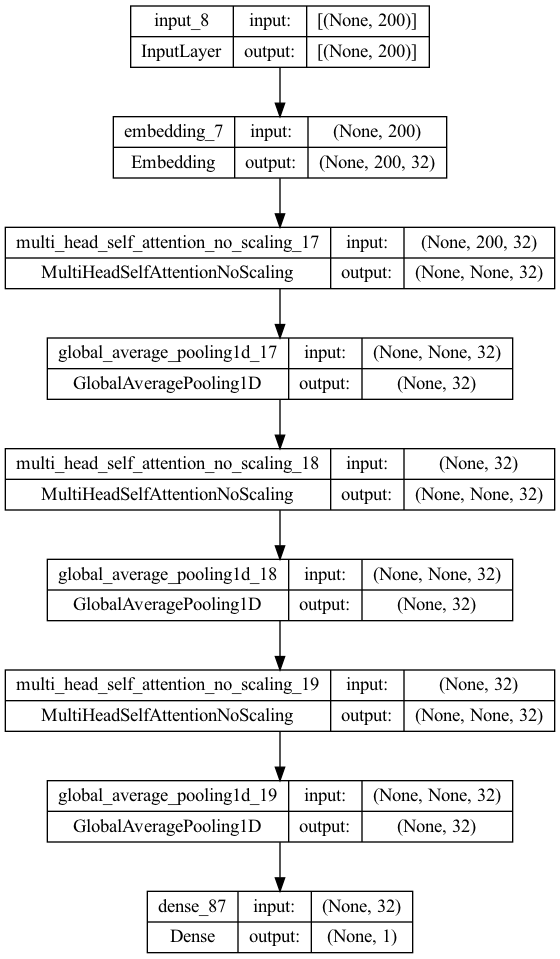

In [25]:
# plot model
tf.keras.utils.plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# do single prediction
# predict probabilities for test set first exemple
yhat_probs = model.predict(x_test, verbose=0)
print(yhat_probs[0])

[0.21767968]
